In [35]:
from typing import List

import medical_image_segmentation.analyze_data.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import json
import os

In [36]:
import matplotlib as mpl
mpl.rc('image', cmap='cool')

In [37]:
def plot_image_shapes(image_shapes: List[List[int]]):
    """
    Plot image sizes on a scatter plot, with more frequent sizes represented by larger points.

    Parameters
    ----------
    image_shapes : List[List[int]] List of width, height pairs.
    """
    shape_counter = Counter(tuple(shape) for shape in image_shapes)
    widths, heights, counts = zip(*[(shape[0], shape[1], count) for shape, count in shape_counter.items()])

    widths = np.array(widths)
    heights = np.array(heights)
    counts = np.array(counts)
    
    max_size = 10_000
    min_size = 1
    point_sizes = np.clip(counts / np.max(counts) * max_size, min_size, max_size)

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, s=point_sizes, c=np.sqrt(widths * heights), alpha=0.8)
    plt.colorbar(label="Sqrt of Area (pixels^2)")
    plt.title("Distribution of DICOM Image Dimensions")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.tight_layout()

    plt.show()

In [38]:
subset_image_path_list_file_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/dicom_image_analysis_info/image_path_list"

In [39]:
with open(subset_image_path_list_file_path, "r") as f:
    files = f.readlines()

files = [file.strip() for file in files]

In [40]:
dimensions_output_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/dicom_image_analysis_info/dicom_image_dimensions.json"

In [41]:
if os.path.isfile(dimensions_output_path):
    with open(dimensions_output_path, "r") as f:
        dimensions = json.load(f)
        subset_dimensions = {}
        for file_path in files:
            subset_dimensions[file_path] = dimensions[file_path]
        
    if len(subset_dimensions) != len(files):
        raise ValueError(f"subset_dimensions has length different than files. Length of files is {len(files)}, and length of subset_dimensions is {len(subset_dimensions)}")
else:
    subset_dimensions = utils.get_dicom_image_dimensions(files, num_processes=8)

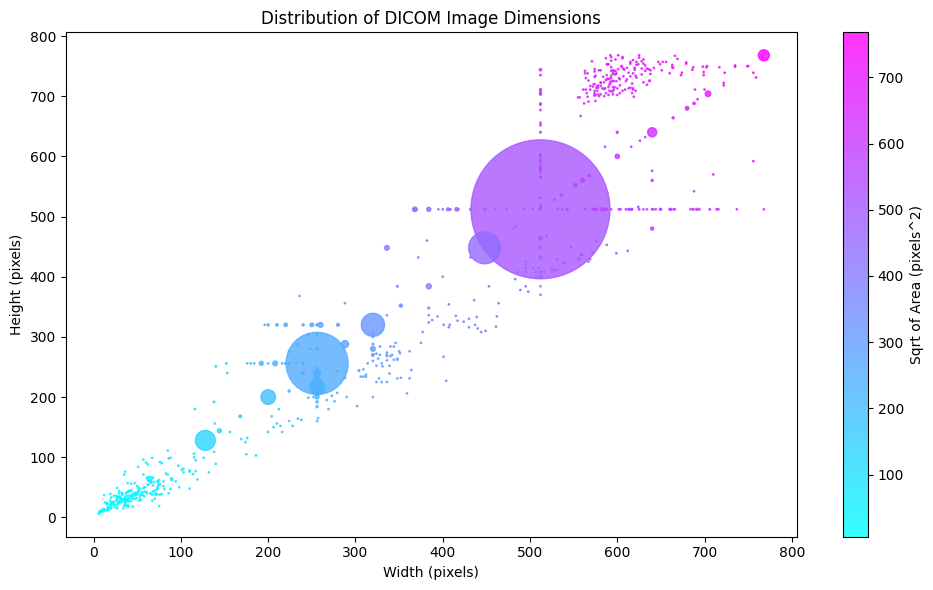

In [42]:
plot_image_shapes(list(subset_dimensions.values()))